# **Introdução sobre o Desafio Técnico:**

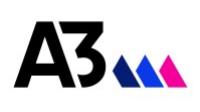
## **Teste Técnico Cientista de Dados**

O teste técnico para a vaga de Cientista de Dados da A3Data consiste na
exploração de uma base de dados com descrições de empresas.

Faça download da base [aqui](https://drive.google.com/file/d/1FrpnWZjNrjpVTdu0sV7M9I2JtI_tC74o/view).

O objetivo deste teste é que você consiga explorar e demonstrar suas
habilidades como Cientista de Dados, principalmente explorando técnicas
de NLP. Seja criativo com as análises. Caso seja necessário, você pode
definir premissas e suposições, basta justificá-las.

Você pode desenvolver o teste em sua linguagem de programação de
preferência.


**Você deverá entregar os seguintes artefatos:**
1. Apresentação dos resultados, que deva conter:
  
  a. Apresentação do desafio
  
  b. Explicação do processo utilizado
  
  c. Hipóteses levantadas
  
  d. Análise exploratória
  
  e. Conclusões e insights gerados
2. Código no GitHub


**O que iremos avaliar:**
1. Capacidade analítica
2. Qualidade do storytelling na apresentação do problema e no código
3. Qualidade e clareza do código

Você irá apresentar o desenvolvimento deste desafio para a equipe da
A3Data. Você terá 30 minutos (25 minutos apresentação + 5 minutos
perguntas).




### Perguntas/hipóteses iniciais sobre o que poderia ser explorado e obtido do dataset em questão:

- Do que se trata essas empresas?
- Frequência das palavras - Fazer uma nuvem de palavras pra ter uma noção básica sobre os tipos de empresa;
- Quais os ramos de atividades dessas empresas?
- Identificar entidades (nome da empresa, ramo de atividade, resumo, localização, ano de criação, etc)

- Ideia: estudar possíveis empresas que poderiam ser clientes da A3Data para ajudar o time comercial.

### Fontes utilizadas para desenvolver esse notebook:

- https://note.nkmk.me/en/python-collections-counter/
- https://analyticsindiamag.com/hands-on-guide-to-pattern-a-python-tool-for-effective-text-processing-and-data-mining/
- https://stackoverflow.com/questions/16566268/remove-all-line-breaks-from-a-long-string-of-text
- https://stackoverflow.com/questions/64743583/which-10-words-has-the-highest-tf-idf-value-in-each-document-total

# **Instalação e importação das bibliotecas necessárias:**

### Instalação das bibliotecas que não vês instaladas por padrão no ambiente do Google Colab:

In [ ]:
# biblioteca para poder usar a API do ChatGPT:
!pip install openai
print('')
print('===============')
print('')

# bibliotecas auxiliares para formatacao de textos:
!pip install unidecode
!pip install pattern
print('')
print('===============')
print('')

### Todas as bibliotecas necessárias estão reunidas na célula abaixo para melhor organização do código:

In [78]:
# bibliotecas para manipulacao basica de dados:
import numpy as np
import pandas as pd
import random
import os

# bibliotecas para trabalhar com datas e horas:
import time
import datetime as dt

# bibliotecas para extrair a manipular dados de APIs e outras fontes externas:
import json
import zipfile
import requests
from google.colab import drive

# bibliotecas para manipulacao e tratamento de textos:
import nltk
import collections
from unidecode import unidecode
from pattern.text.es import singularize

# bibliotecas de modelos de NLP:
import openai
from gensim.models import KeyedVectors

# bibliotecas para gerar graficos e visualizacoes:
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# bibliotecas diversas do SciKit Learn:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# **Configurações iniciais:**

In [4]:
# conectando com o meu Google Drive:
drive.mount('/gdrive')
drive_path = '/gdrive/MyDrive/'

Mounted at /gdrive


In [5]:
# fazendo download das "stopwords" da biblioteca NLTK (Natural Language ToolKit):
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Início do código:**

### Todas as funções necessárias que foram criadas estão declaradas na célula abaixo:

In [111]:
def carrega_dataset(drive_path):

    df = pd.read_csv(f'{drive_path}/id_desc.csv')

    return df


def cria_blacklist():

    blacklist = [
        # INCLUA AQUI AS PALAVRAS QUE DESEJA ELIMINAR,
        # OU POR SER MUITO COMUM E SEM SIGNIFICADO
        # OU OUTRO MOTIVO QUALQUER
    ]

    return blacklist


def cria_lista_palavras_nao_relevantes():

    lista_palavras_nao_relevantes = []

    # lista de stopwords para remover dos nomes dos itens dos pedidos:
    stopwords = nltk.corpus.stopwords.words('english')

    # montando lista negra (palavras selecionadas manualmente):
    blacklist = cria_blacklist()

    lista_palavras_nao_relevantes.append(stopwords)
    lista_palavras_nao_relevantes.append(blacklist)

    lista_palavras_nao_relevantes = [val for sublist in lista_palavras_nao_relevantes for val in sublist]

    return lista_palavras_nao_relevantes



def limpa_frase(frase, lista_palavras_nao_relevantes):

    # passando todas as palavras para minusculo:
    frase = frase.lower()

    # removendo quebras de linha:
    frase = frase.replace('\n', ' ').replace('\r', '')

    # removendo acentos:
    frase = unidecode(frase)

    frase_tratada = []
    for palavra in frase.split(' '):

        palavra_tratada = []
        if palavra not in lista_palavras_nao_relevantes:

            if len(palavra) >= 2:
                palavra = singularize(palavra)

                if palavra not in lista_palavras_nao_relevantes:

                    for letra in palavra:
                        # mantendo apenas letras, removendo numeros e caracteres especiais:
                        if letra.isalpha():
                            palavra_tratada.append(letra)
                        elif letra == '-':
                            palavra_tratada.append(' ')

        palavra_tratada = ''.join(palavra_tratada).strip()

        if palavra_tratada not in lista_palavras_nao_relevantes and len(palavra_tratada) > 2:

            frase_tratada.append(palavra_tratada)


    frase_tratada = ' '.join(frase_tratada).strip()

    return frase_tratada


def nuvem_palavras(df, lista_palavras_nao_relevantes, coluna, cor_fundo='black', titulo=''):

    lista_frases = df[coluna].tolist()
    lista_frases = [limpa_frase(str(item), lista_palavras_nao_relevantes) for item in lista_frases]
    lista_palavras_total = [palavra for item in lista_frases for palavra in item.split()]

    # gerar uma wordcloud:
    wordcloud = WordCloud(
                background_color=cor_fundo,
                width=500, 
                height=500
    ).generate(' '.join(lista_palavras_total))

    # mostrar a imagem final:
    fig, ax = plt.subplots(figsize=(12,8))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_axis_off()

    plt.title(titulo);
    plt.imshow(wordcloud);


def procura_palavra(texto, palavra):
    if palavra.lower() in texto.lower():
        return True
    else:
        return False


def grid_nuvem_palavras(df, lista_palavras_nao_relevantes, coluna, cor_fundo='black'):

    lista_clusters = list(set(clusters))

    fig, ax = plt.subplots(figsize=(20,12), nrows=3, ncols=2)
    fig.tight_layout()

    for cluster_escolhido, ax in zip(lista_clusters, ax.ravel()):
        
        df_temp = df.query(f"cluster == '{cluster_escolhido}'")

        lista_frases = df_temp[coluna].tolist()
        lista_frases = [limpa_frase(str(item), lista_palavras_nao_relevantes) for item in lista_frases]
        lista_palavras_total = [palavra for item in lista_frases for palavra in item.split()]
        

        # gerar uma wordcloud:
        wordcloud = WordCloud(
                    background_color=cor_fundo,
                    width=800, 
                    height=400,
                    stopwords=palavras_muito_comuns
        ).generate(' '.join(lista_palavras_total))

        # mostrar a imagem final:
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_axis_off()
        ax.set_title(f'Cluster: {cluster_escolhido}');
        plt.imshow(wordcloud);
        

def retorna_palavras_e_vetores(lista_palavras, modelo, n_pca=0, n_tsne=0, perplexity=50, metrica_distancia='euclidean'):

    embedd_dict = {}
    for palavra in lista_palavras:
        if palavra in modelo.index_to_key:
            embedd_dict[palavra] = modelo[palavra]

    palavras = list(embedd_dict.keys())
    X_vetores = [embedd_dict[palavra] for palavra in palavras]


    if n_pca > 0:
        pca = PCA(n_components=n_pca)
        X_vetores = pca.fit_transform(X_vetores)


    if n_tsne > 0:
        distri = TSNE(
            n_components=n_tsne, random_state=42, square_distances=True,
            perplexity=perplexity, metric=metrica_distancia
        )
        X_vetores = distri.fit_transform(X_vetores)


    # ideia para transformar os dados antes:
    ##X_vetores = np.log(X_vetores+1)

    ##scaler = MinMaxScaler((0, 1))
    ##X_vetores = scaler.fit_transform(X_vetores)

    return palavras, X_vetores



def cria_clusters(lista_palavras, modelo, n_clusters=3, n_pca=3, n_tsne=3, perplexity=38, metrica_distancia='euclidean', plot_scatter=False):

    palavras, X_vetores = retorna_palavras_e_vetores(
        lista_palavras, modelo, n_pca=n_pca,
        n_tsne=n_tsne, perplexity=perplexity,
        metrica_distancia=metrica_distancia
    )

    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_vetores)

    clusters = kmeans.predict(X_vetores)
    clusters = ['cluster_{}'.format(cluster) for cluster in clusters]

    df_palavras_clusters = pd.DataFrame({
        'palavra': palavras,
        'cluster': clusters,
        'vetor_x': [x[0] for x in X_vetores[:]],
        'vetor_y': [x[1] for x in X_vetores[:]],
        'vetor_z': [x[2] for x in X_vetores[:]]
    })


    if plot_scatter:
        fig = px.scatter_3d(
            X_vetores,
            x=0, y=1, z=2,
            color=clusters,
            text=palavras,
            labels={'0': 'X', '1': 'Y', '2': 'Z'},
            title=f'Gráfico com {n_clusters} clusters: {n_pca} PCs / Perplexity: {perplexity} / Distância: {metrica_distancia}'
        )
        fig.update_layout(
            autosize=True,
            width=800,
            height=700,
            margin={'pad': 0}
        )

        fig.show()

    return kmeans, df_palavras_clusters


def converte_frases_em_vetores(lista_frases, vectorizer, nome_coluna='frase_sem_repeticao'):

    df_frases = pd.DataFrame(lista_frases, columns=[nome_coluna])

    if vectorizer == None:
        vectorizer = TfidfVectorizer(
            min_df=10,
            max_df=0.5,
            ngram_range=(1,2)
            #max_features=1000
        )
        X_tfidf = vectorizer.fit_transform(lista_frases)
    else:
        X_tfidf = vectorizer.transform(lista_frases)

    lista_palavras = vectorizer.get_feature_names_out()

    print(X_tfidf.shape)

    dense = X_tfidf.todense()
    dense_list = dense.tolist()
    df_tfidf = pd.DataFrame(dense_list, columns=lista_palavras)

    df_tfidf = pd.concat([df_frases, df_tfidf], axis=1)

    print(df_tfidf.shape)

    return X_tfidf, df_tfidf, lista_palavras, vectorizer



def chamada_modelo_gpt(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]


def identifica_atributos(description_code):
    prompt = f"""
        I will give you information of some different companies.
        Please, for each one of the companies, identify the following items from the description of the company: 
        - ID of the company
        - Name of the company
        - Type of the company
        - Line of Business of the company
        - Summary of the description of the company, with at most 30 words
        - Location of the company
        - Year the company was founded

        The companies descriptions are delimited with triple backticks. \

        Format your response as a list, with one JSON object for each company, with \
        "Id", "Name", "Type", "LineBusiness", "Summary", "Location" and "Year" as the keys for each JSON object.
        If the information isn't present, use "unknown" as the value.

        Companies descriptions:
        '''
        {description_code}
        '''
    """
    
    response = chamada_modelo_gpt(prompt) #, model='text-davinci-003')
    dict_response = json.loads(response)
    df_response = pd.json_normalize(dict_response)

    return df_response

### 1 - Obter o dataset para usar no resto do código:

In [7]:
df = carrega_dataset(drive_path)
df.shape

(3617, 2)

Existem 3617 descrições de empresas nesse dataset.

In [8]:
# dando uma olhada nos dados contidos no dataset:
df.head()

,id,desc
0,004c744a-2b82-49b3-a536-90dbb68f368e,Vectra is a cybersecurity platform that uses A...
1,0062d2eb-8210-480a-adef-ec91d0e74855,Roadzen is a global leader in the P&C insuranc...
2,00657562-4dd3-41f9-aceb-df114606bc9e,Restream is a multi-streaming solution that al...
3,00b16654-5d01-4f2f-b6b3-ee2ef13c0d9e,DLP works for 1% of companies; fortunately the...
4,00b4e919-4d10-4ce8-b013-b6cf73ebd780,Shift Technology delivers AI-native decision a...


In [20]:
# visualizando uma descricao, pra entender que tipo de conteudo dentro dos textos:
df.sample(1)['desc'].item()

"Zetwerk is an end-to-end manufacturing supply chain solutions provider.The online marketplace connects large manufacturing companies with vendors and suppliers for customized products that are used as components of industrial machines and equipment. The company sells items like crane parts, doors, machine chassis, and ladders, as well as servicesbusinesses in fabrication, machining, casting, and forging.Zetwerk provides both buyers and suppliers collaboration tools to streamline their interactions, and execution tools to fulfill the orders effortlessly as well as plans to host a 3rd party apps and services marketplace to fulfill other customer needs. The company's marketplace offers access to the capacity of a nationwide network of manufacturing facilities to get products manufactured for any budget or timelines, enabling businesses to procure custom products and machine parts and suppliers to obtain more orders and grow their revenues.Zetwerk was founded in 2018 and is headquartered 

### 2 - Preparar o dataset:

- Renomear as colunas;
- Ajustar os tipos de cada coluna, se necessário;
- Verificar se há dados em branco (*missing values*);
- Verificar se há dados repetidos.

In [21]:
# renomeando a coluna 'desc' para 'descricao' para ficar mais amigavel:
df.columns = ['id', 'descricao']

In [ ]:
# verificando os tipos das colunas:
df.info()

Obs.: não houve necessidade de alterar o tipo das colunas

In [23]:
# verificando se ha algum registro em branco:
df.isnull().sum()

id            0
descricao    64
dtype: int64

Há 64 registros sem nada escrito na descrição.
Vou listar para ver do que se trata...

In [ ]:
# listando as linhas com descricao nula:
df[df['descricao'].isna()]

Realmente não há informação nenhuma nesses 64 registros.
Então vou desconsiderá-los...

In [25]:
# mantendo no dataframe apenas os registros cuja descricao nao esteja nula:
df = df[df['descricao'].notna()]

In [26]:
df.shape

(3553, 2)

Sobraram agora 3553 descrições de empresas no dataset.

In [27]:
# verificando se ha dados repetidos:
df['descricao'].nunique()

3452

Se há 3452 descrições distintas, mas 3553 registros, então parece que deve haver descrições idênticas.

Mais precisamente: 3553 - 3452 = 101 descrições repetidas!!

Vou analisar isso...

In [28]:
df_group = df.groupby(by='descricao', as_index=False).agg({
    'id': ['count', 'nunique']
})
df_group.columns = df_group.columns.droplevel(0)
df_group.columns = ['descricao', 'qtde', 'qtde_distinta']

df_group.sort_values(by='qtde', ascending=False).head()

,descricao,qtde,qtde_distinta
662,Cofense provides phishing threat management fo...,2,2
3391,dacadoo is a global technology company that is...,2,2
3067,Unifonic is a leading cloud-based customer co...,2,2
2668,Sift applies insights from a global network of...,2,2
1563,"Justworks makes it easier to start, run, and g...",2,2


In [30]:
df_group.query("qtde > 1").shape

(101, 3)

É isso mesmo!! Há 101 descrições duplicadas no dataset!!

Vou analisar alguns exemplos para tentar entender do que se trata...

In [31]:
# analisando um primeiro exemplo:
df[df['descricao'].str.contains('Cofense')]

,id,descricao
301,a4b703c5-2817-4db4-9205-8b47d7122b9b,Cofense provides phishing threat management fo...
1416,3dfdaa9a-7e93-4d6d-bedf-5e324c30c4ea,Cofense provides phishing threat management fo...


In [32]:
# analisando um outro exemplo:
df[df['descricao'].str.contains('Unifonic')]

,id,descricao
287,9c5c3b0b-33b8-485b-a45f-c63cb858617a,Unifonic is a leading cloud-based customer co...
2708,ae426537-966a-4254-a060-9a0f9e20ac42,Unifonic is a leading cloud-based customer co...


É a mesma descrição, porém com dois IDs diferentes...

**Obs.: como não sei para que serve os IDs e qual importância podem ter mais pra frente no estudo, vou manter esses registros duplicados, pois não sei decidir qual dos IDs manter e qual eliminar para poder tirar essas duplicações.**

[Mas futuramente, caso for necessário eliminar os duplicados, esse é o ponto do código onde isso deve ser feito, antes de continuar a fazer a análise exploratória!!]

### 3 - Análise exploratória dos dados (EDA - Exploratory Data Analysis):

##### Pergunta 1: Quais as palavras que mais aparecem nas descrições das empresas?

In [ ]:
# criar uma lista com todas as descricoes (vou chamar de frases daqui pra frente, para facilitar):
lista_frases = df['descricao'].tolist()

# verificar total de frases:
print(f'Total de frases: {len(lista_frases)}')
print('')

# visualizar os 5 primeiros elementos da lista
lista_frases[0:5]

In [ ]:
# criar uma lista unica com todas as palavras de todas as frases
lista_palavras = [str(palavra) for item in lista_frases for palavra in str(item).split()]

# verificar total de palavras:
print(f'Total de palavras: {len(lista_palavras)}')

# verificar total de palavras distintas:
print(f'Total de palavras distintas: {len(set(lista_palavras))}')
print('')

# visualizar as 100 primeiras palavras:
print(lista_palavras[:100])

In [35]:
# utilizando a biblioteca 'collections' para verificar quais as palavras que mais aparecem:
collections.Counter(lista_palavras).most_common(20)

[('and', 14698),
 ('the', 7644),
 ('to', 7433),
 ('in', 5234),
 ('a', 5081),
 ('of', 5001),
 ('is', 4685),
 ('for', 2963),
 ('that', 2510),
 ('with', 2473),
 ('More', 2405),
 ('by', 1590),
 ('their', 1544),
 ('platform', 1518),
 ('data', 1441),
 ('company', 1428),
 ('on', 1346),
 ('The', 1192),
 ('as', 1121),
 ('an', 1112)]

A maioria das palavras que aparecem nesse TOP 20 não tem significado nenhum!!

São artigos, preposições, conjunções, etc.

Esse tipo de palavra é chamada de 'stopword'.

Vou eliminar essas palavras, com a ajuda da biblioteca NLTK e, em seguida, analisar novamente as TOP 20 palavras mais comuns...

In [54]:
# criando lista com palavras que nao sao relevantes para a analise em questao:
# para isso, criei uma funcao chamada 'cria_lista_palavras_nao_relevantes', que esta na secao de funcoes aqui do notebook, algumas celulas acima:

lista_palavras_nao_relevantes = cria_lista_palavras_nao_relevantes()
print(lista_palavras_nao_relevantes[:100])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once']


Obs.: Nessa lista de palavras não relevantes, estão inclusas tanto as 'stopwords' do `NLTK` como uma blacklist que criei chamando a função `cria_blacklist()`

AGORA, VOU REPETIR O MESMO PROCEDIMENTO DE ANTES, MAS AGORA REMOVENDO AS PALAVRAS NÃO RELEVANTES DAS FRASES:

In [ ]:
# remover palavras nao relevantes das frases (alem de outros preprocessamentos, vide funcao 'limpa_frase'):
lista_frases_limpas = [limpa_frase(str(item), lista_palavras_nao_relevantes) for item in lista_frases]

# verificar total de frases:
print(f'Total de frases: {len(lista_frases_limpas)}')
print('')

# visualizar os 5 primeiros elementos da lista
lista_frases_limpas[0:5]

In [ ]:
# criar uma lista unica com todas as palavras de todas as frases (agora ja limpas):
lista_palavras_limpas = [str(palavra) for item in lista_frases_limpas for palavra in str(item).split()]

# verificar total de palavras:
print(f'Total de palavras: {len(lista_palavras_limpas)}')

# verificar total de palavras distintas:
print(f'Total de palavras distintas: {len(set(lista_palavras_limpas))}')
print('')

# visualizar as 100 primeiras palavras:
print(lista_palavras_limpas[:100])

Muito menos palavras depois de remover as não relevantes!!

Vamos ver quais são as mais comuns agora!!

In [57]:
# utilizando a biblioteca 'collections' para verificar quais as palavras que mais aparecem:
collections.Counter(lista_palavras_limpas).most_common(20)

[('health', 1143),
 ('technology', 1024),
 ('healthcare', 804),
 ('software', 748),
 ('care', 729),
 ('management', 728),
 ('patient', 726),
 ('digital', 634),
 ('learning', 539),
 ('based', 527),
 ('cloud', 521),
 ('intelligence', 502),
 ('team', 491),
 ('serviz', 478),
 ('service', 466),
 ('medical', 464),
 ('online', 445),
 ('global', 422),
 ('deliver', 413),
 ('including', 402)]

Agora parece que as palavras do TOP 20 carregam mais significado semântico!!

Vou partir dessa lista de palavras para continuar a análise exploratória!!

NUVEM DE PALAVRAS: ☁ 🌤 ⛈

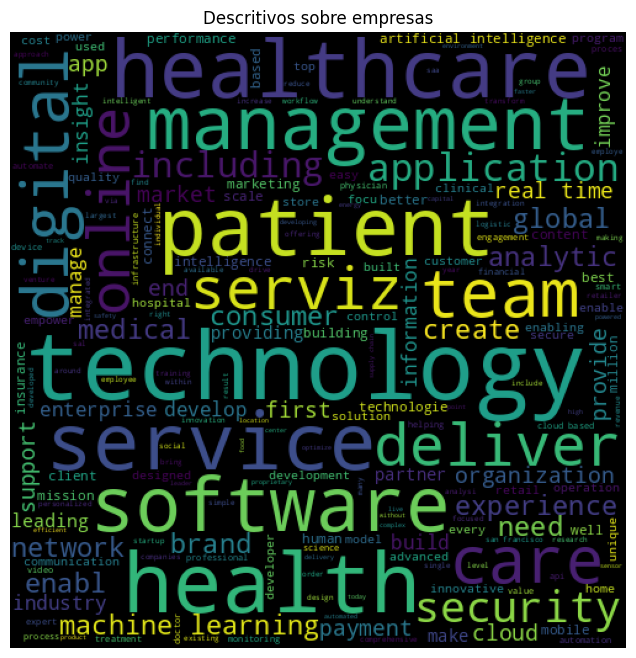

In [58]:
# criei uma funcao para gerar uma nuvem de palavras a partir de um dataset:
# para isso, deve-se passar um dataframe, qual o nome da coluna com os textos e tambem a lista de palavras nao relevantes.
# ai a funcao ja fara automaticamente tudo que foi feita acima, para preprocessar as palavras, antes de exibir na nuvem de palavras:
nuvem_palavras(df, lista_palavras_nao_relevantes, 'descricao', cor_fundo='black', titulo='Descritivos sobre empresas')

A partir dessa **nuvem de palavras**, já é possível verificar algumas coisas:
- Muitas empresas oferecendo soluções para seus clientes, seja uma plataforma, seja um produto digital;
- Parece haver um número considerável de empresas do ramo da saúde, pois aparecem os termos 'Health', 'Healthcare', 'patient';
- Tecnologia parece estar envolvida, de uma forma ou de outra, em grande parte das empresas (ainda não se sabe se é o ramo principal da empresa ou se é um meio para ajudar no funcionamento da empresa).

Continuando a análise, vou agora verificar aspectos mais "técnicos" dos textos, como por exemplo:
- número de caracteres;
- número de palavras;
- existência ou não de determinadas palavras-chave dentro do texto;
- etc.

O objetivo é verificar se a análise dessas informações traz algum insight sobre os dados.

In [41]:
# criar novos atributos para cada descricao:

# tamanho da descricao, em caracteres:
df['num_caracteres'] = df['descricao'].apply(lambda x: len(str(x)))

# tamanho da descricao, em palavras:
df['num_palavras'] = df['descricao'].apply(lambda x: len(str(x).split(' ')))

# flags indicando a existencia ou nao das palavras mais comuns:
df['platform'] = df['descricao'].apply(lambda x: procura_palavra(x, 'platform'))
df['data'] = df['descricao'].apply(lambda x: procura_palavra(x, 'data'))
df['company'] = df['descricao'].apply(lambda x: procura_palavra(x, 'company'))
df['health'] = df['descricao'].apply(lambda x: procura_palavra(x, 'health'))
df['solution'] = df['descricao'].apply(lambda x: procura_palavra(x, 'solution'))
df['technology'] = df['descricao'].apply(lambda x: procura_palavra(x, 'technology'))
df['healthcare'] = df['descricao'].apply(lambda x: procura_palavra(x, 'healthcare'))

In [ ]:
# visualizando como esses atributos ficaram no dataframe:
df.head()

In [43]:
# verificando a distribuicao da quantidade de caracteres e de palavras:
df.describe(include='int')

,num_caracteres,num_palavras
count,3553.000000,3553.000000
mean,529.024205,75.141852
std,378.934178,55.191458
min,11.000000,2.000000
25%,280.000000,40.000000
50%,477.000000,67.000000
75%,688.000000,97.000000
max,5228.000000,786.000000


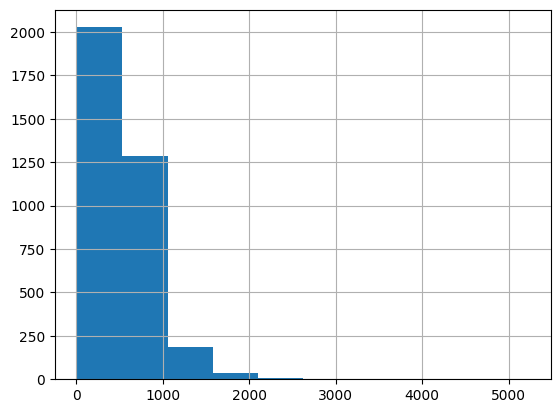

In [44]:
# visualizando um histograma da distribuicao da quantidade de caracteres:
df['num_caracteres'].hist(bins=10);

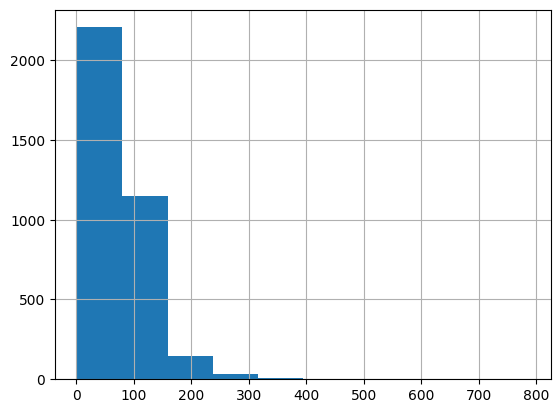

In [45]:
# visualizando um histograma da distribuicao da quantidade de palavras:
df['num_palavras'].hist(bins=10);

In [46]:
# quais as menores descricoes existentes? (em numero de caracteres e/ou numero de palavras):
df.sort_values(by=['num_palavras', 'num_caracteres']).head()

,id,descricao,num_caracteres,num_palavras,platform,data,company,health,solution,technology,healthcare
2421,92dc48c9-3dca-4559-be88-036cd725492b,Health Tech,11,2,False,False,False,True,False,False,False
261,8dae4e58-d785-4193-9a64-4d6c411c357d,Re-commerce Re-imagined,23,2,False,False,False,False,False,False,False
1213,2beef9ee-4c3c-4b35-82fb-7366a22f9109,AI for Healthcare,17,3,False,False,False,True,False,False,True
2493,9926ab91-4742-49d4-bdaf-df8648198ce6,Face Recognition Solutions,26,3,False,False,False,False,True,False,False
3323,e49fff88-b8cd-4bbd-b8a4-5cb7ca3c1a4a,Pillar provides fintech services.,33,4,False,False,False,False,False,False,False


Para essas empresas, como há muito pouco escrito na descrição, será difícil extrair muitas informações relevantes, como o nome da empresa, o que ela faz, de onde é, etc.

Algumas talvez seja possível apenas pegar o nome ou então o ramo de atividade, mas não tudo.

In [47]:
# quais as maiores descricoes existentes? (em numero de caracteres e/ou numero de palavras):
df.sort_values(by=['num_palavras', 'num_caracteres'], ascending=False).head()

,id,descricao,num_caracteres,num_palavras,platform,data,company,health,solution,technology,healthcare
507,2c97cb8e-e75f-4ae4-bd31-abb484a57295,MDsave provides a single online location for c...,5228,786,False,False,True,True,False,True,True
1485,43f59da1-2466-430b-92e3-22b9d394df60,There are phrases of how we integrate our core...,4918,739,True,True,False,False,True,False,False
1602,4dba7ec4-7731-40b5-9663-d25caff1bf7c,Molekule began in San Francisco in 2014 with a...,4624,735,False,False,True,True,True,True,True
2872,bc515936-8077-4da0-b37a-b762cbe87f07,Accedian Networks is the leader in Performance...,4202,526,True,True,False,False,True,True,False
3473,f2aa937e-b0e7-487c-9316-08b44a8381b7,"In B2B, the biggest challenge marketers face i...",3244,521,True,True,False,False,True,False,False


In [48]:
# visualizando o texto completo de uma das empresas:
df.sort_values(by=['num_palavras', 'num_caracteres'], ascending=False).head(1)['descricao'].item()

'MDsave provides a single online location for consumers to research, compare, and purchase medical services with total cost transparency.MDsave has announced the addition of laboratory/pathology services to its medical service listings.  With the proliferation of high deductible health plans, the push for price transparency is a hot topic.MDsave, a Brentwood, TN based healthcare startup, is aiming to be an “Expedia of health care”.  MDsave is the first e-commerce company to offer a single online resource for consumers to research, compare, and purchase healthcare services at significant discounts.  Launched June 2012, MDsave is already in 3 large metro markets and likely to expand to another 4 this year.MDsave is in partnership with SSM Healthcare Oklahoma, parent organization to St Anthony Hospital. The partnership encompasses more than 225 healthcare providers across 20 locations and over 200 procedures and services that include MRIs, flue shots, CT scans, and specialty visits.With t

Com essas descrições bem longas, será possível extrair diversas informações relevantes de dentro do texto, então dará para fazer uma análise bem rica para esses casos.

Por exemplo, para essa descrição impressa acima, é possível identificar o nome da empresa, o que ela faz, em que ano foi criada, em que localidade, etc.

In [49]:
# verificando frequencia da aparicao das palavras-chave (algumas das palavras que apareceram no TOP 20 de mais comuns):

# por exemplo, a palavra 'technology':
df['technology'].value_counts(dropna=False, normalize=True)

False    0.763862
True     0.236138
Name: technology, dtype: float64

Quase 25% das empresas desse dataset citam pelo menos uma vez a palavra tecnologia. **(Isso pode indicar alguma coisa?!? A se pensar)**

In [51]:
# palavra 'platform'
df['platform'].value_counts(dropna=False, normalize=True)

False    0.592457
True     0.407543
Name: platform, dtype: float64

A palavra 'platform' aparece na descrição de 40% das empresas!! **(O que isso significa?!? Não sei ainda...)**

In [52]:
# proporcao de empresas que citam as palavras 'health' ou 'healthcare':

qtde = df.query("health == True or healthcare == True").shape[0]
qtde_total = df.shape[0]
proporcao = np.round(qtde/qtde_total*100, 2)

print(f'Qtde empresas com as palavras health ou healthcare: {qtde}')
print(f'Qtde total de empresas: {qtde_total}')
print(f'Proporção: {proporcao}%')

Qtde empresas com as palavras health ou healthcare: 943
Qtde total de empresas: 3553
Proporção: 26.54%


Pela análise acima, parece que mais de 25% das empresas estão de alguma forma relacionada com o ramo da saúde e/ou cuidados com a saúde.

##### Pergunta 2: Existem similaridades entre as descrições das empresas? Será que é possível agrupar as empresas baseando-se em quão "próximas" as palavras de cada texto são?

In [60]:
# lista de palavras muito comuns para ajudar a diferenciar os grupos:
palavras_muito_comuns = [
    'based', 'customer', 'founded', 'help', 'acros', 'companie', 'busines',
    'solution', 'time', 'world', 'system', 'new', 'product', 'offer',
    'people', 'provid', 'provider', 'real', 'business', 'use', 'user', 'one',
    'to', 'tool', 'using', 'way', 'work', 'acces', 'allow', 'also',
    'of the', 'on', 'demand', 'californiaread', 'statesread', 'headquartered', 'of', 'the',
    'data', 'company', 'platform', 'solution'
]

In [61]:
# transformar cada frase em um vetor, utilizando o TF-IDF (Term Frequency – Inverse Document Frequency):
vectorizer_custom = TfidfVectorizer(
    min_df=50,
    max_df=0.3,
    ngram_range=(1,5),
    max_features=100,
    # conforme fui testando, fui aumentando essa lista de stopwords especificamente para esse modelo:
    stop_words=palavras_muito_comuns
)
vectorizer_custom.fit_transform(lista_frases_limpas)

<3553x100 sparse matrix of type '<class 'numpy.float64'>'
	with 25990 stored elements in Compressed Sparse Row format>

In [62]:
# criei uma funcao chamada 'converte_frases_em_vetores' para fazer justamente isso:
X_tfidf, df_tfidf, lista_palavras, vectorizer = converte_frases_em_vetores(
    lista_frases=lista_frases_limpas,
    vectorizer=vectorizer_custom,
    nome_coluna='frase_limpa'
)

(3553, 100)
(3553, 101)


In [ ]:
df_tfidf['descricao'] = df['descricao']
df_tfidf.head()

In [64]:
lista_palavras[:20]

array(['advanced', 'analytic', 'app', 'application', 'artificial',
       'artificial intelligence', 'best', 'better', 'brand', 'build',
       'building', 'built', 'care', 'clinical', 'cloud', 'connect',
       'consumer', 'content', 'control', 'cost'], dtype=object)

Testei várias combinações de parâmetros no Vectorizer até acabar chegando nessa combinação, desconsiderando unigramas e só considerando de bigramas para cima.

Entendi que esses bigramas iriam representar mais a semântica das frases.

In [ ]:
# tentando criar grupos similares (clusters), utilizando o algoritmo K-Means:
n_clusters = 6
n_pca = 3

X_vetores = df_tfidf.drop(['frase_limpa', 'descricao'], axis=1)
frases = df_tfidf['descricao'].tolist()

# reduzindo a dimensionalidade antes de passar para o K-Means:
pca = PCA(n_components=n_pca)
X_vetores = pca.fit_transform(X_vetores)

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_vetores)

clusters = kmeans.predict(X_vetores)
clusters = ['cluster_{}'.format(cluster) for cluster in clusters]

In [66]:
# proporcao da explicacao da variancia dos dados que se mantem apos a aplicacao do PCA: 
pca.explained_variance_.sum()

0.08901204104364766

In [67]:
# criando dataframe com as frases, os clusters atribuidos a cada frase 
# e os 3 primeiros componentes principais do PCA, para poder visualizar as frases em um grafico 3D:
df_frases_clusters = pd.DataFrame({
    'frase': frases,
    'cluster': clusters,
    'vetor_x': [x[0] for x in X_vetores[:]],
    'vetor_y': [x[1] for x in X_vetores[:]],
    'vetor_z': [x[2] for x in X_vetores[:]]
})

In [68]:
# visualizando uma amostra dos dados desse dataframe:
df_frases_clusters.sample(5)

,frase,cluster,vetor_x,vetor_y,vetor_z
2135,Zest AI makes the power of machine learning sa...,cluster_2,-0.150893,0.074679,-0.019993
3442,CaliberMind develops a B2B customer data platf...,cluster_0,0.325979,0.025439,-0.502669
1796,Giift is a loyalty solutions provider that add...,cluster_1,-0.053276,0.019054,-0.055845
694,Immunai is a biotech company that combines sin...,cluster_4,-0.188064,0.516989,0.135594
3346,how.fm is transforming manual laborers’ onboar...,cluster_1,-0.100190,-0.157426,-0.004558


In [69]:
# quantidade de frases atribuida a cada cluster:
df_frases_clusters['cluster'].value_counts(dropna=False)

cluster_1    2145
cluster_0     465
cluster_2     319
cluster_3     232
cluster_5     225
cluster_4     167
Name: cluster, dtype: int64

In [82]:
print(len(X_vetores))
print(len(clusters))
print(len(frases))

3553
3553
3553


In [83]:
# pegar apenas uma amostra das frases para conseguir visualizar no grafico 3D:
amostra = random.sample(range(len(frases)), 500)
len(amostra)

500

In [106]:
# visualizando um grafico 3D com todas as frases e suas posicoes no "espaco":
fig = px.scatter_3d(
    X_vetores[amostra],
    x=0, y=1, z=2,
    color=[clusters[i] for i in amostra],
    text=[frase[:10] if len(str(frase)) >= 10 else frase for frase in [frases[i] for i in amostra]],
    labels={'0': 'X', '1': 'Y', '2': 'Z'},
    title=f'Gráfico com {n_clusters} clusters'
)
fig.update_layout(
    autosize=True,
    width=800,
    height=700,
    margin={'pad': 0}
)

fig.show()

Obs.: difícil de visualizar as frases no gráfico 3D e entender suas similaridades, ainda mais por estar exibindo apenas um pequeno trecho do texto de cada frase.

In [ ]:
# analisando as palavras mais comuns em cada um dos clusters:
for i in range(0, n_clusters):
    cluster_escolhido = f'cluster_{i}'
    df_temp = df_frases_clusters.query(f"cluster == '{cluster_escolhido}'")
    nuvem_palavras(df_temp, lista_palavras_nao_relevantes, 'frase', cor_fundo='white', titulo=cluster_escolhido)

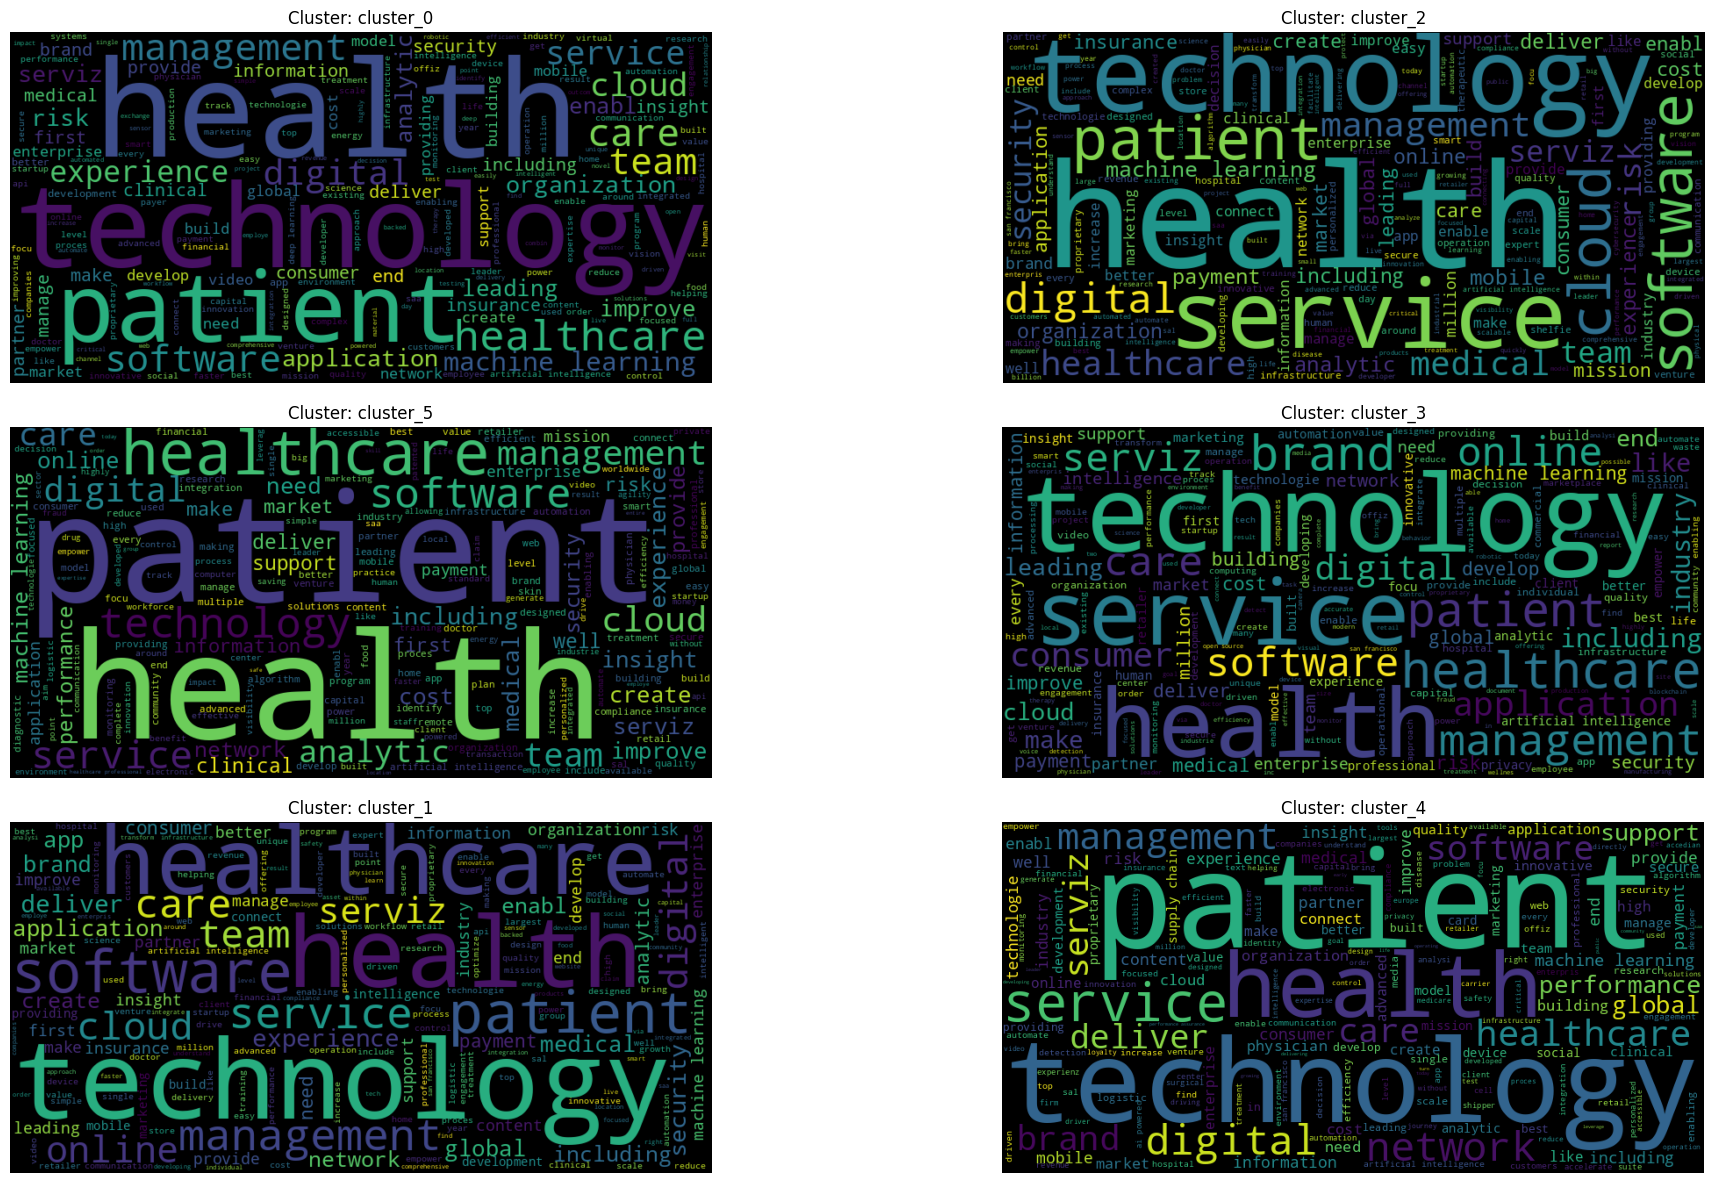

In [73]:
# montando as nuvens em um grid mais bonitinho:
grid_nuvem_palavras(df_frases_clusters, lista_palavras_nao_relevantes, coluna='frase', cor_fundo='black')

Mais uma ideia: analisar o universo de palavras das descrições das empresas no espaço vetorial de um Word Embedding:

In [74]:
# baixando um modelo de 50 dimensoes (Word2Vec):
url = 'http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s50.zip'
r = requests.get(url, allow_redirects=True)

# escrevendo o arquivo em disco:
with open("cbow_s50.zip", "wb") as f:
    f.write(r.content)

# descompactando o arquivo:
dataset_zip = 'cbow_s50.zip'
local_zip = dataset_zip
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.')
zip_ref.close()

# salvando o arquivo em uma variavel do tipo KeyedVectors:
modelo_cbow_50 = KeyedVectors.load_word2vec_format('cbow_s50.txt', binary=False)

In [77]:
len(lista_palavras_limpas)

156144

In [80]:
# criei uma funcao chamada 'cria_clusters' que cria grupos a partir da similaridade das palavras e exibe em um espaco vetorial reduzido de 3 dimensoes:
amostra = random.sample(lista_palavras_limpas, 1000)

# sao muitas palavras (mais de 150 mil), entao peguei soh uma amostra para visualizar como ficaria no grafico 3D:
kmeans, df_temp = cria_clusters(
    amostra, modelo_cbow_50, n_clusters=3, n_pca=3, n_tsne=3, 
    perplexity=38, metrica_distancia='euclidean', plot_scatter=True
)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:841: FutureWarning:

The parameter `square_distances` has not effect and will be removed in version 1.3.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



##### Pergunta 3: É possível identificar "entidades" dentro dos textos, como por exemplo, nome da empresa, ramo de atividade, localidade, ano de fundação, etc?

Para isso, utilizei a API da OpenAI, com um dos modelos do ChatGPT, o modelo "gpt-3.5-turbo".

Ele possui uma limitação, de até 3 chamadas por minuto, então criei uma estratégia para conseguir fazer perguntas de uma sequência de empresas de cada vez, não uma de cada vez. E também de esperar um tempo antes de fazer a próxima chamada, para não estourar o limite por minuto.

In [107]:
# chave para acessar a API da OpenAI:
openai.api_key = os.getenv('OPENAI_API_KEY')

Obs.: antes de rodar a célula acima, é preciso salvar a chave gerada no site da OpenAI em uma variável de ambiente para depois conseguir acessá-la através dessa função `os.getenv()` e atribuir para a `openai.api_key`

Essa variável de ambiente pode ser configurada através do seguinte comando:
`!export OPENAI_API_KEY='sk-...'`

In [109]:
# pegar apenas a coluna 'descricao' para passar para o ChatGPT:
df.sample(2)

,id,descricao,num_caracteres,num_palavras,platform,data,company,health,solution,technology,healthcare
2735,b0212202-863f-42fa-8a5a-f7a1f1666b7c,Consumer Ventures is a venture capital and adv...,130,20,False,False,False,False,False,False,False
1823,6123e4f4-ab5c-4e9e-990d-2e6a6830fa46,BioIntelliSense is ushering in a new era of co...,672,87,True,True,False,True,True,False,False


In [ ]:
# exemplo da execucao de uma chamada da API do GPT, com um batch_size de 10:
# mas eu rodei para as mais de 3 mil descricoes das empresas e salvei em uma planilha para usar nas celulas seguintes:

batch_size = 10
df_total = pd.DataFrame()

start_time = dt.datetime.now()
print(f'Início Total: {start_time}')
print('')

for i in range(0,1):
    start = dt.datetime.now()
    print(f'Início Batch {i}: {start}')
    description_code = ''
    for idx, row in df.loc[batch_size*i:batch_size*i+batch_size-1].iterrows():

        description_code = description_code + f'Company {idx+1}:\n'
        description_code = description_code + 'ID: ' + str(row['id']) + '\n'
        description_code = description_code + str(row['descricao'])
        description_code = description_code + '\n\n'

    # chamada da funcao que monta um prompt para solicitar as informacoes sobre o texto e retornar um JSON:
    df_response = identifica_atributos(description_code)

    df_total = pd.concat([df_total, df_response], axis=0, ignore_index=True)
    
    end = dt.datetime.now()
    duracao = end - start
    print(f'Fim Batch {i}: {end}')
    print(f'Duração Batch {i}: {duracao}')
    print('')
    print('=========')
    print('')

    time.sleep(20)
    print()

end_time = dt.datetime.now()
duration = end_time - start_time
print('')
print(f'Fim Total: {end_time}')
print(f'Duração Total: {duration}')

Obs.: rodei o código da célula abaixo para todas as descrições do dataset e salvei em uma planilha para não perder os dados (levou algumas horas para processar a informação para o dataset inteiro). Então, na célula abaixo, vou fazer a leitura dessa planilha e aí continuar a análise...

In [113]:
# dataframe com as primeiras 10 empresas:
df_total

,Id,Name,Type,LineBusiness,Summary,Location,Year
0,004c744a-2b82-49b3-a536-90dbb68f368e,Vectra,Cybersecurity platform,Cloud and network detection and response (NDR),Vectra is a cybersecurity platform that uses A...,"San Jose, California",2011
1,0062d2eb-8210-480a-adef-ec91d0e74855,Roadzen,P&C insurance technology,"Auto underwriting, claims and assistance, tele...",Roadzen is a global leader in the P&C insuranc...,unknown,unknown
2,00657562-4dd3-41f9-aceb-df114606bc9e,Restream,Multi-streaming solution,Live video streaming and analytics,Restream is a multi-streaming solution that al...,"Austin, Texas",2015
3,00b16654-5d01-4f2f-b6b3-ee2ef13c0d9e,Cyberhaven,Data protection,Data Detection and Response (DDR),"Cyberhaven makes data protection simple, accur...",unknown,unknown
4,00b4e919-4d10-4ce8-b013-b6cf73ebd780,Shift Technology,AI-native decision automation and optimization...,Insurance policy lifecycle,Shift Technology delivers AI-native decision a...,unknown,unknown
5,00c83f0f-9a68-4145-8fea-e58f970541c8,Clutch,Online car buying,Certified vehicles,Clutch is a Toronto-based technology company t...,unknown,unknown
6,01569c3d-df62-4033-8539-89bef1a69d34,FoodLogiQ,Supplier management,"Food safety compliance, quality incident, and ...","FoodLogiQ specializes in supplier management, ...",unknown,unknown
7,0169b008-e0a9-4613-ac97-14c28486a38a,3DFortify,Advanced manufacturing,Aligned reinforced carbon fiber composites,3DFortify is an advanced manufacturing startup...,unknown,unknown
8,0275df14-12b1-4056-99ea-913738197922,gradient A.I.,Data analysis and machine intelligence,Insurance and healthcare industries,gradient A.I. is tackling some of the most cha...,unknown,unknown
9,02e1c98c-c3d7-4b70-b8d3-d0a182dd3ef9,WebPT,Rehab therapy platform,"Billing, managing a practice, and delivering q...",WebPT is a rehab therapy platform designed for...,"Phoenix, Arizona",2008


Já é possível perceber que o modelo do ChatGPT consegue extrair informações muito interessantes das descrições. Vou recuperar os dados para todas as empresas e continuar a análise...

In [114]:
# lendo a planilha que salvei com todos os dados:
df_total = pd.read_excel(f'{drive_path}/dataset_enriquecido_chatgpt.xlsx')
df_total.shape

(3617, 8)

In [116]:
# visualizando uma amostra dos dados:
df_total.sample(5)

,id,desc,name,type,line_business,summary,location,year
256,8bb66b01-d4b1-4d86-80cb-b464ca681188,Rever connects a global community of motorcycl...,Rever,Motorcycle Community,NaN,Rever connects a global community of motorcycl...,"Eagle, Colorado",2015
2027,722e6eb8-ea10-4d3f-bfd6-898a2beaf78b,Sama provides accurate data for artificial int...,Sama,Technology,Data Annotation and Validation for Machine Lea...,Sama provides accurate data for artificial int...,"San Francisco, California, United States",2018
3580,fc66c387-37be-4b01-9cac-c92c6149ed7c,Censys invented internet-wide scanning and has...,Censys,Attack Surface Management,Comprehensive inventory of internet-facing ass...,Censys invented internet-wide scanning and has...,unknown,unknown
521,366e3cc6-5db2-4d13-bb5e-a0ad1093805b,WellBridge Healthcare is a mental healthcare p...,WellBridge Healthcare,Mental healthcare provider,NaN,WellBridge Healthcare offers behavioral health...,unknown,unknown
2689,ac9784ae-782f-4a28-b207-62606f0376ba,The modern R&D cloud platform designed to unco...,Labstep,unknown,R&D cloud platform,Labstep is a modern R&D cloud platform designe...,unknown,unknown


De posse desses dados, vou ver com mais detalhes o que existe dentro desse dataset...

In [118]:
# verificando quantidade de empresas por tipo:
df_total['type'].value_counts(dropna=False)

unknown                                             432
Technology                                          144
Healthcare                                          143
Software                                             53
Artificial Intelligence                              26
                                                   ... 
B2B SaaS                                              1
Information company                                   1
Customer Experience Management Software Provider      1
Customer Data Orchestration Tools Provider            1
Enterprise Security Platform                          1
Name: type, Length: 2183, dtype: int64

Muitas ainda aparecem sem essa informação, ou porque o modelo não conseguiu identificar ou porque realmente essa informação não estava presente no texto.

Além disso, os tipos que mais aparecem são os esperados mesmo, "Technology" e "Healthcare", seguido por "Software" e "Artificial Intelligence".

Seria possível analisar mais a fundo essas classificações e fazer ajustes finos, agrupando algumas, alterando outras, mas pela limitação de tempo, não farei isso nesse momento. Vou apenas considerar as classificações obtidas pelo modelo.

In [119]:
# verificando se aparecem empresas com o mesmo nome:
df_total['name'].value_counts(dropna=False)

unknown         163
NaN               8
ReliaQuest        2
Seldon            2
Aware             2
               ... 
Pega Plantão      1
Bloomreach        1
Superwise.ai      1
Picsart           1
Intertech         1
Name: name, Length: 3314, dtype: int64

Parece que há alguns casos de empresas com o mesmo nome (ou pelo menos, o que o modelo do ChatGPT "entendeu" ter o mesmo nome).

Analisando isso mais a fundo...

In [120]:
# juntando esses dados com os dados anteriores (descricao original e outros atributos criados antes):
df_final = pd.merge(df, df_total, on='id', how='left', indicator=True)
df_final.shape

(3553, 19)

In [121]:
df_final['_merge'].value_counts(dropna=False)

both          3553
left_only        0
right_only       0
Name: _merge, dtype: int64

Obs.: a célula acima indica que nenhuma descrição ficou de fora, ou seja, todas elas foram analisadas e processadas pelo modelo do ChatGPT...


In [127]:
df_final.drop('_merge', axis=1, inplace=True)

In [122]:
df_final.sample(3)

,id,descricao,num_caracteres,num_palavras,platform,data,company,health,solution,technology,healthcare,desc,name,type,line_business,summary,location,year,_merge
3269,e5e54050-005f-4221-8de2-bebdd1b8e682,Recogni was incorporated in 2017 to help auto ...,265,39,True,False,True,False,False,False,False,Recogni was incorporated in 2017 to help auto ...,Recogni,Technology,Autonomous vehicles,Recogni delivers unprecedented inference perfo...,unknown,2017,both
3408,f257d8c1-0f9f-43e7-a76d-bca1712f8347,Athenium Analytics provides insurance software...,127,17,False,False,False,False,True,False,False,Athenium Analytics provides insurance software...,Athenium Analytics,unknown,Insurance software,Provides insurance software for QA auditing an...,unknown,unknown,both
2908,c4edd656-7105-4f4b-9ae6-70360a68c206,Inspektlabs is a computer vision technology st...,363,56,False,False,True,False,False,True,False,Inspektlabs is a computer vision technology st...,Inspektlabs,unknown,Computer vision technology for automating insp...,Inspektlabs automates inspections of physical ...,unknown,unknown,both


In [124]:
df_group = df_final.groupby(by=['name'], as_index=False).agg({
    'id': ['count']
})
df_group.columns = df_group.columns.droplevel(0)
df_group.columns = ['nome', 'qtde']
df_group.sort_values(by='qtde', ascending=False)

,nome,qtde
3307,unknown,108
2670,Spryker,2
978,EvolutionIQ,2
1323,ID.me,2
2558,Shift Technology,2
...,...,...
1128,Genesys,1
1129,Genetron Health,1
1130,GenexEHR,1
1131,Genies,1


In [125]:
df_group.query("qtde > 1").sort_values(by='qtde', ascending=False)

,nome,qtde
3307,unknown,108
2372,ReliaQuest,2
2576,Sift,2
2570,Shopware,2
2564,Shipper,2
...,...,...
1093,Fortanix,2
1071,Flowbox,2
1070,Flow,2
1068,Florence,2


In [ ]:
# verificando todos os casos sem nome (unknown):
df_final.query("name == 'unknown'")

Realmente, os textos não parecem citar explicitamente o nome das empresas.
Poderia investigar mais isso, mas pela limitação de tempo, vou manter assim esses casos.

In [128]:
# analisando alguns casos de nomes de empresas repetidos:
df_final.query("name == 'Spryker' ")

,id,descricao,num_caracteres,num_palavras,platform,data,company,health,solution,technology,healthcare,desc,name,type,line_business,summary,location,year
116,38e45826-8e32-40eb-9aac-a76f329172e1,Spryker is a provider of a commerce technology...,549,77,True,False,True,False,True,True,False,Spryker is a provider of a commerce technology...,Spryker,Commerce technology platform,NaN,Spryker is a provider of a commerce technology...,unknown,unknown
1648,54135e6a-5667-4990-a378-25c41f112642,Spryker is a provider of a commerce technology...,549,77,True,False,True,False,True,True,False,Spryker is a provider of a commerce technology...,Spryker,Commerce technology platform,NaN,Spryker is a provider of a commerce technology...,unknown,unknown


In [129]:
# analisando alguns casos de nomes de empresas repetidos:
df_final.query("name == 'ReliaQuest' ")

,id,descricao,num_caracteres,num_palavras,platform,data,company,health,solution,technology,healthcare,desc,name,type,line_business,summary,location,year
247,8bbd62cd-088e-4aac-8aae-55ebdcd4b354,ReliaQuest provides a SaaS security platform d...,371,49,True,True,True,False,False,False,False,ReliaQuest provides a SaaS security platform d...,ReliaQuest,SaaS Security,NaN,ReliaQuest provides a SaaS security platform d...,"Tampa, Florida",2007
1073,2279100d-4576-4130-b768-12fe3375b60d,ReliaQuest provides a SaaS security platform d...,371,49,True,True,True,False,False,False,False,ReliaQuest provides a SaaS security platform d...,ReliaQuest,SaaS security platform,NaN,ReliaQuest provides a SaaS security platform d...,"Tampa, Florida",2007


Pela limitação de tempo, vou manter desse jeito mesmo, por ser uma quantidade pequena de casos, mas o ideal seria tratar esses casos repetidos (mas qual ID manter, já que cada registro possue um ID diferente pra mesma descrição de empresa?!?)

In [130]:
# verificando quantidade de empresas por ramo de atividade:
df_final['line_business'].value_counts(dropna=False)

NaN                                                               1922
Healthcare                                                          22
unknown                                                             21
Healthcare technology                                                3
Technology                                                           3
                                                                  ... 
AI-driven Hiring Intelligence platform                               1
AI-driven data analytics platform for e-commerce companies           1
Mobile and virtual healthcare for people of all ages                 1
Industry solutions using advanced AI technologies                    1
Security platform for AWS, Azure, Google Cloud, and Kubernetes       1
Name: line_business, Length: 1571, dtype: int64

Imensa maioria das empresas está sem os dados do ramo de atividade (tive a ideia de acrescentar essa informação bem depois, quando eu já havia consultado grande parte das empresas usando a API, por isso que estão como NaN), mas com mais tempo, eu iria trabalhar mais em tentar identificar essa informação para todas as empresas, porque acredito ser algo relevante.

In [131]:
# verificando quantidade de empresas por localidade:
df_final['location'].value_counts(dropna=False)

unknown                                  2370
San Francisco, California                  69
Unknown                                    27
New York City                              23
Boston, Massachusetts                      22
                                         ... 
Silicon Valley, USA                         1
Bangalore, India                            1
Edmonton, Calgary and Toronto, Canada       1
Miami Beach, Florida                        1
Edmonton, AB, Canada                        1
Name: location, Length: 570, dtype: int64

Interessante!! Quase 70 empresas são de São Francisco, na Califórnia.

Infelizmente, para a imensa maioria das empresas, não foi possível identificar a localidade, seja por limitação do modelo, seja por realmente a informação não estar contida no texto. Independente do motivo, não vou investigar mais a fundo pela limitação do tempo, mas seria algo bem interessante de fazer, verificar o que é possível fazer para melhorar a qualidade dos dados contidos nessa coluna.

In [144]:
# sera que existem empresas em outros paises que nao USA, India ou Canada??

# procurando coisas do Brasil, por exemplo:
df_final[df_final['location'].str.contains('Brazil')]

,id,descricao,num_caracteres,num_palavras,platform,data,company,health,solution,technology,healthcare,desc,name,type,line_business,summary,location,year
733,04baba0f-0782-430a-9a5f-ef5730fc4129,GoEPIK is an augmented reality platform that i...,674,103,True,True,True,False,True,False,False,GoEPIK is an augmented reality platform that i...,GoEPIK,unknown,NaN,Augmented reality platform that integrates all...,"Parana, Brazil",2017
754,069be583-b387-40f6-acd9-29f6f67cf7b3,Epitrack develops a tool designed to assess an...,636,96,False,False,False,True,False,False,True,Epitrack develops a tool designed to assess an...,Epitrack,Healthcare,NaN,Epitrack develops a tool designed to assess an...,"Recife, Brazil",2013
784,08d8e6be-56fa-4a01-bf96-3db6d6569a6e,SantéMed is a software company that optimizes ...,187,28,False,False,True,False,False,False,False,SantéMed is a software company that optimizes ...,SantéMed,Software,NaN,Software company that optimizes hospital and c...,"Parana, Brazil",2015
814,0b1bdac3-3822-45ac-af65-9143f12a26a7,TNH Health creates AI-powered chatbots to help...,1167,166,False,False,True,True,True,False,True,TNH Health creates AI-powered chatbots to help...,TNH Health,unknown,NaN,Creates AI-powered chatbots to help healthcare...,Brazil,unknown
957,18bc21d8-67a9-4214-9571-f33daf3d101f,Nanovetores Group is an innovative company kno...,1515,193,False,False,True,False,False,True,False,Nanovetores Group is an innovative company kno...,Nanovetores Group,Company,NaN,Nanovetores is a Brazilian company that develo...,Brazil,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3504,fb20a3bb-c1fe-4142-96aa-f5ea2a3c11d5,Fácil Consulta is a booking platform that allo...,190,32,True,False,True,False,False,False,False,Fácil Consulta is a booking platform that allo...,Fácil Consulta,unknown,Booking platform for specialist physicians,Fácil Consulta is a booking platform that allo...,"Pelotas, Brazil",2017
3506,fb4b5507-b623-4775-897d-9cda3304caef,ProRadis is building the foundations for a rea...,539,76,True,False,False,True,True,False,False,ProRadis is building the foundations for a rea...,ProRadis,unknown,Health sector technology,ProRadis is building the foundations for a rea...,"São Paulo, Brazil",2012
3511,fba3a6f7-42a7-456d-8255-d9f66274117e,I9access is a software development company tha...,535,76,False,False,True,True,True,False,True,I9access is a software development company tha...,I9access,Software development,Software solutions for health professionals an...,I9access provides software solutions to fill t...,"Porto Alegre, Brazil",2009
3517,fc858e9f-0512-497e-859e-5d82fc2ba67c,Sempre Tecnologia da Informação develops syste...,615,93,True,False,False,False,True,True,False,Sempre Tecnologia da Informação develops syste...,Sempre Tecnologia da Informação,unknown,Information Technology,Develops systems with own technology in web pl...,"Brasilia, Brazil",unknown


Ideia: listar empresas com potencial de serem clientes da A3Data!!!
Começando com o filtro que sejam do Brasil...

In [145]:
# lendo mais as descricoes das empresas que o ChatGPT "entendeu" serem do Brasil:
for descricao in df_final[df_final['location'].str.contains('Brazil')]['descricao']:
    print(descricao)
    print('')

GoEPIK is an augmented reality platform that integrates all industry units by linking the real world with the virtual world. It allows the resolution of problems common to production lines, reducing costs, and increasing productivity.The company is able to collect evidence of process execution and real-time data from the procedures facilitatingmore assertive decision making and the correction of contingencies. For the platform to work, operators need to have smartphones or tablets and, in some cases, augmented reality glasses that will guide them through the shop floor and allow the processes to run.GoEPIK was founded in 2017 and is based in Parana, Brazil.Read More

Epitrack develops a tool designed to assess and track changes in cognitive function in people with epilepsy. It uses a short list of critical questions and visual indicators to assist healthcare professionals (HCPs) in detecting problems with attention and executive function. The screening tool when used repeatedly, allows

Obs.: passando o olho nas descricoes das empresas, identifiquei o nome de algumas delas, entao parece que o ChatGPT as classificou bem como sendo do Brasil.

In [149]:
# sera que existe alguma empresa de Minas Gerais??
df_final[
    df_final['location'].str.contains('Minas') |
    df_final['location'].str.contains('Gerais') |
    df_final['location'].str.contains('MG')
]

,id,descricao,num_caracteres,num_palavras,platform,data,company,health,solution,technology,healthcare,desc,name,type,line_business,summary,location,year
2171,802d3082-f5d6-491b-92e4-ea872431998a,Termoweb enables the electronic management and...,477,68,False,True,False,False,False,False,False,Termoweb enables the electronic management and...,Termoweb,Temperature and humidity data management,Electronic management and automation of temper...,Enables the electronic management and automati...,"Uberlândia, Minas Gerais",2015
2929,c6bfff3c-888a-46b0-9245-59d8fa0a7cb1,iMedicina is an online health platform that en...,425,61,True,False,False,True,False,False,True,iMedicina is an online health platform that en...,iMedicina,Online Health Platform,Online health platform for doctors,Online health platform for doctors to store an...,"Minas Gerais, Brazil",2011


Encontradas duas empresas de Minas Gerais!!!

In [150]:
# primeira:
df_final.query("id == '802d3082-f5d6-491b-92e4-ea872431998a' ")['descricao'].item()

'Termoweb enables the electronic management and automation of temperature and humidity data in a wide range of situations. With the help of\xa0Termoweb resources, it is possible to provide a wide variety of information for automatic and real-time monitoring of aberrations in the transport and storage production process, allowing for the execution ofprompt corrective and preventative actions.Termoweb is headquartered in Uberlândia, Minas Gerais and was founded in 2015.Read More'

In [151]:
# segunda:
df_final.query("id == 'c6bfff3c-888a-46b0-9245-59d8fa0a7cb1' ")['descricao'].item()

'iMedicina is an online health platform that enables doctors to store and utilize health information records on one platform. The information entered to the system is automatically categorized by algorithms and crosses with a number of services for healthcare.iMedicina also provides clinical and consulting software full medical marketing services.It was founded in 2011 and is headquartered in Minas Gerais, Brazil.Read More'

Poderiam ser avaliados outras questões além da localidade, como outras características do trabalho realizado pela empresa, o ano de fundação, etc, outras questões para serem usadas de insumos para ajudar a equipe comercial a decidir e entrar em contato com essas empresas para oferecer serviços personalizados e torná-las clientes, mas pela limitação do tempo, vou terminar essa análise por aqui.

Outra coisa que poderia ser feita que só pensei agora seria ter "pedido" pro ChatGPT para classificar melhor a localidade, não assim muito genericamente. Eu poderia ter "pedido" cidade, estado, país, continente. Assim, eu teria maneiras mais fáceis de classificar e encontrar as empresas. Mas isso fica para uma próxima vez!! ;)

### 4 - Conclusões:

- Existem diversas ferramentas disponíveis hoje em dia para trabalhar com dados textuais e fazer análises de linguagem natural (NLP);
- Com essas análises iniciais, já foi possível tirar alguns insights e informações relevantes sobre essas empresas;
- Não é possível obter informação no caso das descrições muito curtas, então para esses casos, seria necessário pensar em outras soluções para obter dados dessas empresas;
- Muitas empresas são de tecnologia (ou trabalham indiretamente com tecnologia) e muitas também no ramo de saúde;

### 5 - Possíveis próximos passos:

- Analisar mais a fundo a distribuição das palavras nos textos, a fim de encontrar mais similaridades e quem sabe pode agrupar as empresas a partir dessas similaridades (outros modelos de clustering, outras combinações de parâmetros e opções para os modelos já usados, outros modelos de Word Embedding, etc);
- Analisar mais a fundo a similaridade entre as frases como um todo, não só as palavras isoladamente, pois isso poderia dar mais insights ainda sobre os clusters diferentes de empresas e quem sabe até ser possível criar "perfis" de empresas, de maneira similar ao que é feito para perfis de clientes pessoa física;
- Testar mais opções de prompt para a API do ChatGPT para conseguir obter mais informações e também com mais qualidade, como já comentado acima (outros atributos como cidade, estado, país, outras maneiras de pedir um resumo da empresa para servir para outros propósitos, outras maneiras de pedir o tipo, categoria ou ramo de atividade das empresas, para ter mais informações preenchidas, etc);
- Integrar esses dados com possíveis dados obtidos na internet, por exemplo: criar um robô que faça Web Scraping e pesquise mais dados estruturados a partir da coluna da nome da empresa, já obtida anteriormente com o ChatGPT. Assim, seria possível enriquecer o banco de dados com informações cadastrais das empresas, como o website da empresa, catálogo de produtos da empresa, endereço da empresa, etc;
- Utilizar todos esses dados obtidos nas ideias acima, junto com o time comercial, para bolar ideias de como listar clientes em potencial, baseado em critérios a serem definidos pelo comercial, como por exemplo: tipo de empresa, país de origem, tipos de produtos que fornecem, etc, etc.
